# **مسئله اول **

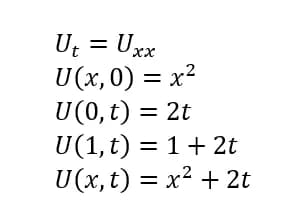

# **الگوریتم عقاب BES **

بهترین θ‌ها (BES): [ 6.99870085e-16  1.12990122e-16  2.00000000e+00  1.00000000e+00
 -2.35199840e-16  8.32192778e-15]
کمینه تابع هزینه (BES): 5.4028518244635454e-14
PDE RMSE: 0.000000
Initial Condition RMSE: 0.000000
Boundary Left RMSE: 0.000000
Boundary Right RMSE: 0.000000

مقایسه حل تحلیلی و تقریبی در چند نقطه:
(x=0.00, t=0.00) -> U_exact = 0.000000, U_approx = 0.000000, Error = 6.998701e-16
(x=0.50, t=0.50) -> U_exact = 1.250000, U_approx = 1.250000, Error = 1.332268e-15
(x=1.00, t=1.00) -> U_exact = 3.000000, U_approx = 3.000000, Error = 0.000000e+00
(x=0.25, t=0.75) -> U_exact = 1.562500, U_approx = 1.562500, Error = 4.440892e-16
(x=0.75, t=0.25) -> U_exact = 1.062500, U_approx = 1.062500, Error = 1.332268e-15

میانگین خطا: -0.000000
میانگین قدرمطلق خطا: 0.000000


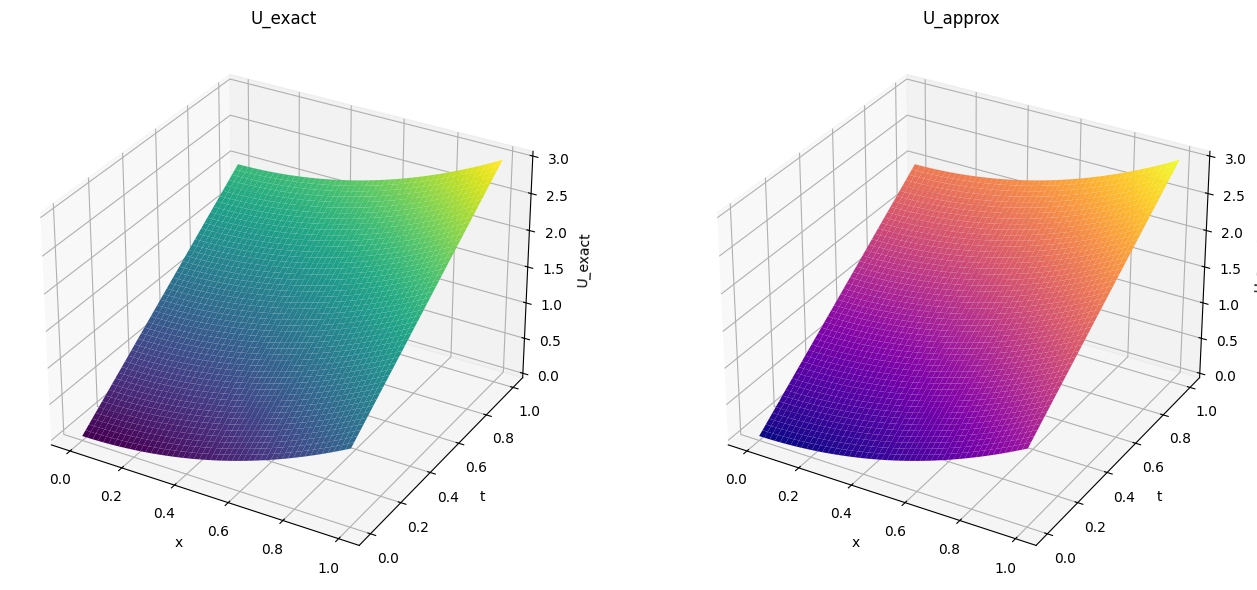

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0)

# تابع حل تقریبی
def U_approx(x, t, theta):
    return (theta[0] + theta[1]*x + theta[2]*t +
            theta[3]*x**2 + theta[4]*x*t + theta[5]*t**2)

# حل دقیق
def U_exact(x, t):
    return x**2 + 2*t

# تابع هزینه (کرانک نیکلسون)
def fitness_function_fd(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2*U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = [(U[0, j] - x_vals[j]**2)**2 for j in range(num_x)]
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_err  = [(U[i, 0] - 2*t_vals[i])**2 for i in range(num_t)]
    bc_right_err = [(U[i, -1] - (1 + 2*t_vals[i]))**2 for i in range(num_t)]
    bc_left_rmse  = np.sqrt(np.mean(bc_left_err))
    bc_right_rmse = np.sqrt(np.mean(bc_right_err))

    λ_init, λ_bc = 1, 1
    total_loss = pde_rmse + λ_init*init_rmse + λ_bc*(bc_left_rmse + bc_right_rmse)

    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم عقاب سرسفید (BES)
def bes_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                  alpha=2, a=10, R=1.5, c1=2, c2=2):
    np.random.seed(0)
    population = np.random.rand(pop_size, dimensions)
    fitness = np.array([fitness_function(ind)[0] for ind in population])

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx].copy()
    best_fitness = fitness[best_idx]

    for _ in range(max_iterations):
        for i in range(pop_size):
            # Exploitation
            r = np.random.rand()
            new_pos = best_solution + alpha * r * (population.mean(axis=0) - population[i])
            new_fit = fitness_function(new_pos)[0]
            if new_fit < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit

            # Exploration
            theta = a * np.pi * np.random.rand()
            r_val = theta + R * np.random.rand()
            xr = r_val * np.sin(theta)
            yr = r_val * np.cos(theta)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = (population[i]
                       + y * (population[i] - population[(i + 1) % pop_size])
                       + x * (population[i] - population.mean(axis=0)))
            new_fit = fitness_function(new_pos)[0]
            if new_fit < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit

            # Swoop
            theta = a * np.pi * np.random.rand()
            r_val = theta
            xr = r_val * np.sinh(theta)
            yr = r_val * np.cosh(theta)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = (np.random.rand() * best_solution
                       + x * (population[i] - c1 * population.mean(axis=0))
                       + y * (population[i] - c2 * best_solution))
            new_fit = fitness_function(new_pos)[0]
            if new_fit < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit

    return best_solution, best_fitness

# اجرای اصلی
if __name__ == "__main__":
    pop_size = 40
    dimensions = 6
    max_iterations = 300

    best_theta, best_loss = bes_algorithm(lambda th: fitness_function_fd(th),
                                          pop_size, dimensions, max_iterations)

    print("بهترین θ‌ها (BES):", best_theta)
    print("کمینه تابع هزینه (BES):", best_loss)

    _, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = fitness_function_fd(best_theta)
    print(f"PDE RMSE: {pde_rmse:.6f}")
    print(f"Initial Condition RMSE: {init_rmse:.6f}")
    print(f"Boundary Left RMSE: {bc_left_rmse:.6f}")
    print(f"Boundary Right RMSE: {bc_right_rmse:.6f}")

    # مقایسه حل تحلیلی و تقریبی در چند نقطه
    print("\nمقایسه حل تحلیلی و تقریبی در چند نقطه:")
    sample_points = [(0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (0.25, 0.75), (0.75, 0.25)]
    for x, t in sample_points:
        approx = U_approx(x, t, best_theta)
        exact = U_exact(x, t)
        print(f"(x={x:.2f}, t={t:.2f}) -> U_exact = {exact:.6f}, U_approx = {approx:.6f}, Error = {abs(exact - approx):.6e}")

    # محاسبه RMSE و MAE روی شبکه
    x_vals = np.linspace(0, 1, 50)
    t_vals = np.linspace(0, 1, 50)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            err = U_approx(x, t, best_theta) - U_exact(x, t)
            errors.append(err)
            abs_errors.append(abs(err))
    print(f"\nمیانگین خطا: {np.mean(errors):.6f}")
    print(f"میانگین قدرمطلق خطا: {np.mean(abs_errors):.6f}")

    # رسم نمودار سه‌بعدی
    X, T = np.meshgrid(x_vals, t_vals)
    U_exact_vals = np.vectorize(U_exact)(X, T)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title('U_exact')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('U_exact')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title('U_approx')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('U_approx')

    plt.tight_layout()
    plt.show()


# **الگوریتم ازدحام ذرات PSO**

بهترین θ‌ها (PSO): [-1.45411226e-12  5.87162759e-12  2.00000000e+00  1.00000000e+00
 -7.84365140e-12  1.81805154e-12]
کمینه تابع هزینه (PSO): 7.059568059419767e-12
PDE RMSE: 0.000000
Initial Condition RMSE: 0.000000
Boundary Left RMSE: 0.000000
Boundary Right RMSE: 0.000000

مقایسه حل تحلیلی و تقریبی در چند نقطه:
(x=0.00, t=0.00) -> U_exact = 0.000000, U_approx = -0.000000, Error = 1.454112e-12
(x=0.50, t=0.50) -> U_exact = 1.250000, U_approx = 1.250000, Error = 3.848033e-13
(x=1.00, t=1.00) -> U_exact = 3.000000, U_approx = 3.000000, Error = 3.049117e-12
(x=0.25, t=0.75) -> U_exact = 1.562500, U_approx = 1.562500, Error = 5.242473e-13
(x=0.75, t=0.25) -> U_exact = 1.062500, U_approx = 1.062500, Error = 7.822631e-13

میانگین خطا: -0.000000
میانگین قدرمطلق خطا: 0.000000


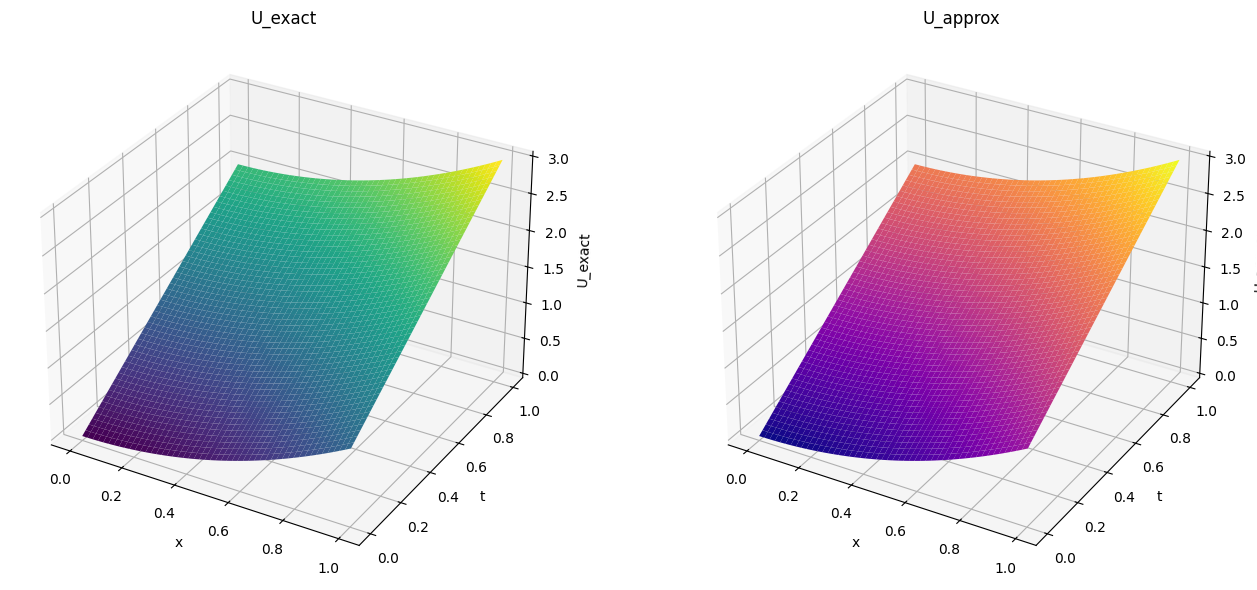

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0)
# تابع حل تقریبی
def U_approx(x, t, theta):
    return (theta[0] + theta[1]*x + theta[2]*t +
            theta[3]*x**2 + theta[4]*x*t + theta[5]*t**2)

# حل دقیق
def U_exact(x, t):
    return x**2 + 2*t

# تابع هزینه (کرانک نیکلسون)
def fitness_function_fd(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2*U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = [(U[0, j] - x_vals[j]**2)**2 for j in range(num_x)]
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_err  = [(U[i, 0] - 2*t_vals[i])**2 for i in range(num_t)]
    bc_right_err = [(U[i, -1] - (1 + 2*t_vals[i]))**2 for i in range(num_t)]
    bc_left_rmse  = np.sqrt(np.mean(bc_left_err))
    bc_right_rmse = np.sqrt(np.mean(bc_right_err))

    λ_init, λ_bc = 1, 1
    total_loss = pde_rmse + λ_init*init_rmse + λ_bc*(bc_left_rmse + bc_right_rmse)

    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم PSO
def pso_algorithm(fitness_function, pop_size, dimensions, max_iter,
                  w=0.7, c1=1.5, c2=1.5, bounds=(-2, 2)):
    np.random.seed(0)
    pos = np.random.uniform(bounds[0], bounds[1], (pop_size, dimensions))
    vel = np.zeros_like(pos)
    personal_best = pos.copy()
    personal_best_val = np.array([fitness_function(ind)[0] for ind in pos])
    global_best = personal_best[np.argmin(personal_best_val)]
    global_best_val = np.min(personal_best_val)

    for _ in range(max_iter):
        for i in range(pop_size):
            r1, r2 = np.random.rand(dimensions), np.random.rand(dimensions)
            vel[i] = (w * vel[i]
                      + c1 * r1 * (personal_best[i] - pos[i])
                      + c2 * r2 * (global_best - pos[i]))
            pos[i] += vel[i]
            pos[i] = np.clip(pos[i], bounds[0], bounds[1])
            fit = fitness_function(pos[i])[0]
            if fit < personal_best_val[i]:
                personal_best[i] = pos[i].copy()
                personal_best_val[i] = fit
                if fit < global_best_val:
                    global_best = pos[i].copy()
                    global_best_val = fit
    return global_best, global_best_val

# اجرای اصلی
if __name__ == "__main__":
    pop_size = 40
    dimensions = 6
    max_iterations = 300

    best_theta, best_loss = pso_algorithm(lambda th: fitness_function_fd(th),
                                          pop_size, dimensions, max_iterations)

    print("بهترین θ‌ها (PSO):", best_theta)
    print("کمینه تابع هزینه (PSO):", best_loss)

    _, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = fitness_function_fd(best_theta)
    print(f"PDE RMSE: {pde_rmse:.6f}")
    print(f"Initial Condition RMSE: {init_rmse:.6f}")
    print(f"Boundary Left RMSE: {bc_left_rmse:.6f}")
    print(f"Boundary Right RMSE: {bc_right_rmse:.6f}")

    # مقایسه حل تحلیلی و تقریبی در چند نقطه
    print("\nمقایسه حل تحلیلی و تقریبی در چند نقطه:")
    sample_points = [(0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (0.25, 0.75), (0.75, 0.25)]
    for x, t in sample_points:
        approx = U_approx(x, t, best_theta)
        exact = U_exact(x, t)
        print(f"(x={x:.2f}, t={t:.2f}) -> U_exact = {exact:.6f}, U_approx = {approx:.6f}, Error = {abs(exact - approx):.6e}")

    # محاسبه RMSE و MAE روی شبکه
    x_vals = np.linspace(0, 1, 50)
    t_vals = np.linspace(0, 1, 50)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            err = U_approx(x, t, best_theta) - U_exact(x, t)
            errors.append(err)
            abs_errors.append(abs(err))
    print(f"\nمیانگین خطا: {np.mean(errors):.6f}")
    print(f"میانگین قدرمطلق خطا: {np.mean(abs_errors):.6f}")
    # رسم نمودار سه‌بعدی حل تحلیلی و تقریبی
    from mpl_toolkits.mplot3d import Axes3D

    X, T = np.meshgrid(x_vals, t_vals)
    U_exact_vals = np.vectorize(U_exact)(X, T)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)

    fig = plt.figure(figsize=(14, 6))

    # نمودار حل تحلیلی
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title('U_exact')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('U_exact')

    # نمودار حل تخمینی
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title('U_approx')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('U_approx')

    plt.tight_layout()
    plt.show()


# **الگوریتم ژنتیک GA**

بهترین θ‌ها (GA): [0.2961402  0.11898484 0.67939277 0.84640867 0.4236548  0.64589411]
کمینه تابع هزینه (GA): 1.0777040583399788
PDE RMSE: 0.419882
Initial Condition RMSE: 0.303532
Boundary Left RMSE: 0.255433
Boundary Right RMSE: 0.098858

مقایسه حل تحلیلی و تقریبی در چند نقطه:
(x=0.00, t=0.00) -> U_exact = 0.000000, U_approx = 0.296140, Error = 2.961402e-01
(x=0.50, t=0.50) -> U_exact = 1.250000, U_approx = 1.174318, Error = 7.568160e-02
(x=1.00, t=1.00) -> U_exact = 3.000000, U_approx = 3.010475, Error = 1.047539e-02
(x=0.25, t=0.75) -> U_exact = 1.562500, U_approx = 1.331082, Error = 2.314178e-01
(x=0.75, t=0.25) -> U_exact = 1.062500, U_approx = 1.151136, Error = 8.863555e-02

میانگین خطا: -0.032982
میانگین قدرمطلق خطا: 0.134343


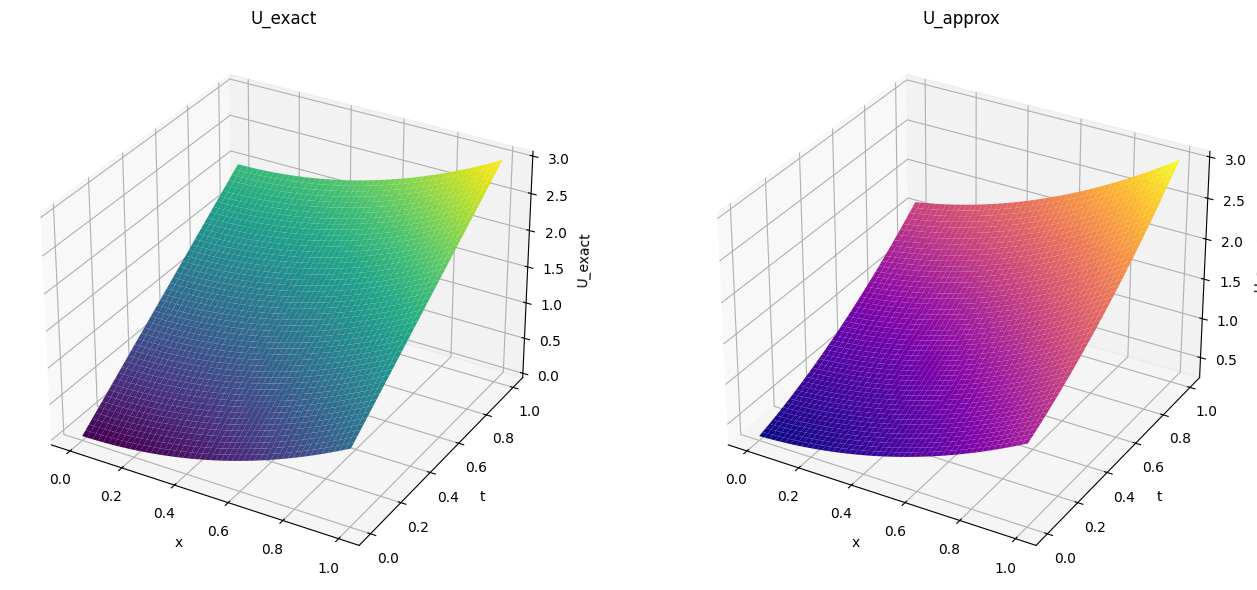

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0)

# تابع حل تقریبی
def U_approx(x, t, theta):
    return (theta[0] + theta[1]*x + theta[2]*t +
            theta[3]*x**2 + theta[4]*x*t + theta[5]*t**2)

# حل دقیق
def U_exact(x, t):
    return x**2 + 2*t

# تابع هزینه (کرانک نیکلسون)
def fitness_function_fd(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2*U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = [(U[0, j] - x_vals[j]**2)**2 for j in range(num_x)]
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_err  = [(U[i, 0] - 2*t_vals[i])**2 for i in range(num_t)]
    bc_right_err = [(U[i, -1] - (1 + 2*t_vals[i]))**2 for i in range(num_t)]
    bc_left_rmse  = np.sqrt(np.mean(bc_left_err))
    bc_right_rmse = np.sqrt(np.mean(bc_right_err))

    λ_init, λ_bc = 1, 1
    total_loss = pde_rmse + λ_init*init_rmse + λ_bc*(bc_left_rmse + bc_right_rmse)

    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم ژنتیک
def ga_algorithm(fitness_func, pop_size, dim, generations, crossover_rate=0.8, mutation_rate=0.1):
    def crossover(p1, p2):
        point = np.random.randint(1, dim)
        c1 = np.concatenate([p1[:point], p2[point:]])
        c2 = np.concatenate([p2[:point], p1[point:]])
        return c1, c2

    def mutate(ind):
        idx = np.random.randint(dim)
        ind[idx] += np.random.normal(0, 0.1)
        return ind

    population = np.random.rand(pop_size, dim)
    fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
    best_idx = np.argmin(fitness_vals)
    best_solution = population[best_idx].copy()
    best_fit = fitness_vals[best_idx]
    best_errors = fitness_func(best_solution)[1:]

    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            p1, p2 = population[np.random.choice(pop_size, 2, replace=False)]
            if np.random.rand() < crossover_rate:
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if np.random.rand() < mutation_rate:
                c1 = mutate(c1)
            if np.random.rand() < mutation_rate:
                c2 = mutate(c2)
            new_pop.extend([c1, c2])
        population = np.array(new_pop[:pop_size])
        fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
        best_idx = np.argmin(fitness_vals)
        if fitness_vals[best_idx] < best_fit:
            best_solution = population[best_idx].copy()
            best_fit = fitness_vals[best_idx]
            best_errors = fitness_func(best_solution)[1:]

    return best_solution, best_fit, best_errors

# اجرای اصلی
if __name__ == "__main__":
    pop_size = 40
    dimensions = 6
    max_iterations = 300

    best_theta, best_loss, _ = ga_algorithm(lambda th: fitness_function_fd(th),
                                            pop_size, dimensions, max_iterations)

    print("بهترین θ‌ها (GA):", best_theta)
    print("کمینه تابع هزینه (GA):", best_loss)

    _, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = fitness_function_fd(best_theta)
    print(f"PDE RMSE: {pde_rmse:.6f}")
    print(f"Initial Condition RMSE: {init_rmse:.6f}")
    print(f"Boundary Left RMSE: {bc_left_rmse:.6f}")
    print(f"Boundary Right RMSE: {bc_right_rmse:.6f}")

    # مقایسه حل تحلیلی و تقریبی در چند نقطه
    print("\nمقایسه حل تحلیلی و تقریبی در چند نقطه:")
    sample_points = [(0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (0.25, 0.75), (0.75, 0.25)]
    for x, t in sample_points:
        approx = U_approx(x, t, best_theta)
        exact = U_exact(x, t)
        print(f"(x={x:.2f}, t={t:.2f}) -> U_exact = {exact:.6f}, U_approx = {approx:.6f}, Error = {abs(exact - approx):.6e}")

    # محاسبه RMSE و MAE روی شبکه
    x_vals = np.linspace(0, 1, 50)
    t_vals = np.linspace(0, 1, 50)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            err = U_approx(x, t, best_theta) - U_exact(x, t)
            errors.append(err)
            abs_errors.append(abs(err))
    print(f"\nمیانگین خطا: {np.mean(errors):.6f}")
    print(f"میانگین قدرمطلق خطا: {np.mean(abs_errors):.6f}")

    # رسم نمودار سه‌بعدی حل تحلیلی و تقریبی
    X, T = np.meshgrid(x_vals, t_vals)
    U_exact_vals = np.vectorize(U_exact)(X, T)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)

    fig = plt.figure(figsize=(14, 6))

    # نمودار حل تحلیلی
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title('U_exact')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('U_exact')

    # نمودار حل تخمینی
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title('U_approx')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('U_approx')

    plt.tight_layout()
    plt.show()


# **الگوریتم وال یا نهنگ WOA**

Best θ: [ 0.19092302 -0.03191327  1.          0.88672042  0.54908279  0.48384434]
Total Loss: 0.7200157466531403
PDE RMSE: 3.170572e-01
Initial Condition RMSE: 1.434644e-01
Boundary Left RMSE: 2.161532e-01
Boundary Right RMSE: 4.334093e-02

میانگین خطا: -0.062981
میانگین قدرمطلق خطا: 0.095603

مقایسه حل تحلیلی و تقریبی در چند نقطه:
(x=0.00, t=0.00) -> U_exact = 0.000000, U_approx = 0.190923, Error = 1.909230e-01
(x=0.50, t=0.50) -> U_exact = 1.250000, U_approx = 1.154878, Error = 9.512173e-02
(x=1.00, t=1.00) -> U_exact = 3.000000, U_approx = 3.078657, Error = 7.865729e-02
(x=0.25, t=0.75) -> U_exact = 1.562500, U_approx = 1.363480, Error = 1.990198e-01
(x=0.75, t=0.25) -> U_exact = 1.062500, U_approx = 1.048962, Error = 1.353841e-02


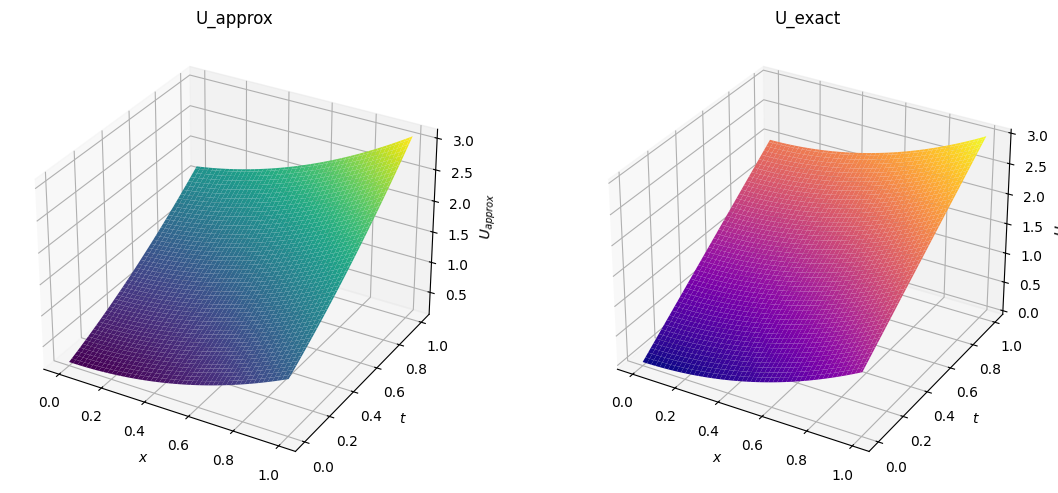

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# حل تقریبی U(x,t)
# -----------------------------
def U_approx(x, t, theta):
    return (theta[0] + theta[1]*x + theta[2]*t +
            theta[3]*x**2 + theta[4]*x*t + theta[5]*t**2)

# -----------------------------
# حل دقیق U(x,t)
# -----------------------------
def U_exact(x, t):
    return x**2 + 2*t

# -----------------------------
# تابع هزینه با روش کرانک–نیکلسون
# -----------------------------
def fitness_function_fd(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n = (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2*U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = [(U[0, j] - x_vals[j]**2)**2 for j in range(num_x)]
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_err  = [(U[i, 0] - 2*t_vals[i])**2 for i in range(num_t)]
    bc_right_err = [(U[i, -1] - (1 + 2*t_vals[i]))**2 for i in range(num_t)]
    bc_left_rmse  = np.sqrt(np.mean(bc_left_err))
    bc_right_rmse = np.sqrt(np.mean(bc_right_err))

    λ_init, λ_bc = 1, 1
    total_loss = pde_rmse + λ_init*init_rmse + λ_bc*(bc_left_rmse + bc_right_rmse)

    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# -----------------------------
# الگوریتم WOA بر اساس مقاله میرجلیلی
# -----------------------------
def woa_algorithm(fitness_func, pop_size, dim, max_iter):
    np.random.seed(0)
    lb = -1.0
    ub = 1.0
    population = np.random.uniform(lb, ub, (pop_size, dim))
    fitness_vals = [fitness_func(ind)[0] for ind in population]

    best_idx = np.argmin(fitness_vals)
    best_pos = population[best_idx].copy()
    best_score = fitness_vals[best_idx]

    for iter in range(max_iter):
        a = 2 - iter * (2 / max_iter)  # عامل کاهش خطی a ∈ [2, 0]
        for i in range(pop_size):
            r1 = np.random.rand()
            r2 = np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()

            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * best_pos - population[i])
                    new_pos = best_pos - A * D
                else:
                    rand_idx = np.random.randint(pop_size)
                    rand_pos = population[rand_idx]
                    D = abs(C * rand_pos - population[i])
                    new_pos = rand_pos - A * D
            else:
                b = 1
                l = np.random.uniform(-1, 1)
                D = abs(best_pos - population[i])
                new_pos = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_pos

            # محدودسازی به بازه تعریف‌شده
            new_pos = np.clip(new_pos, lb, ub)

            new_score = fitness_func(new_pos)[0]
            if new_score < fitness_vals[i]:
                population[i] = new_pos
                fitness_vals[i] = new_score
                if new_score < best_score:
                    best_score = new_score
                    best_pos = new_pos.copy()

    return best_pos, best_score

# -----------------------------
# اجرای الگوریتم
# -----------------------------
if __name__ == "__main__":
    pop_size = 40
    dimensions = 6
    max_iter = 300

    best_theta, best_loss = woa_algorithm(fitness_function_fd, pop_size, dimensions, max_iter)

    print("Best θ:", best_theta)
    print("Total Loss:", best_loss)
    _, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = fitness_function_fd(best_theta)
    print(f"PDE RMSE: {pde_rmse:.6e}")
    print(f"Initial Condition RMSE: {init_rmse:.6e}")
    print(f"Boundary Left RMSE: {bc_left_rmse:.6e}")
    print(f"Boundary Right RMSE: {bc_right_rmse:.6e}")
    # محاسبه RMSE و MAE روی شبکه
    x_vals = np.linspace(0, 1, 50)
    t_vals = np.linspace(0, 1, 50)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            err = U_approx(x, t, best_theta) - U_exact(x, t)
            errors.append(err)
            abs_errors.append(abs(err))
    print(f"\nمیانگین خطا: {np.mean(errors):.6f}")
    print(f"میانگین قدرمطلق خطا: {np.mean(abs_errors):.6f}")

        # مقایسه حل تحلیلی و تقریبی در چند نقطه
    print("\nمقایسه حل تحلیلی و تقریبی در چند نقطه:")
    sample_points = [(0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (0.25, 0.75), (0.75, 0.25)]
    for x, t in sample_points:
        approx = U_approx(x, t, best_theta)
        exact = U_exact(x, t)
        print(f"(x={x:.2f}, t={t:.2f}) -> U_exact = {exact:.6f}, U_approx = {approx:.6f}, Error = {abs(exact - approx):.6e}")
    # -----------------------------
    # ترسیم حل تقریبی و تحلیلی به صورت سه‌بعدی
    # -----------------------------
    x_vals = np.linspace(0, 1, 100)
    t_vals = np.linspace(0, 1, 100)
    X, T = np.meshgrid(x_vals, t_vals)

    U_pred = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_true = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, T, U_pred, cmap='viridis')
    ax1.set_title("U_approx", fontsize=12)
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$t$")
    ax1.set_zlabel("$U_{approx}$")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, T, U_true, cmap='plasma')
    ax2.set_title("U_exact", fontsize=12)
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$t$")
    ax2.set_zlabel("$U_{exact}$")

    plt.tight_layout()
    plt.show()


# **مسئله دوم **

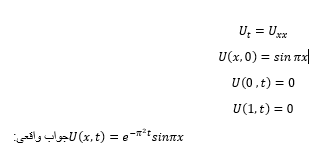


# **الگوریتم عقاب  BES **

Best θ: [ 1.00000000e+00 -1.32317767e-16 -1.55356763e-16  1.50871891e-16]
Total Loss: 3.201450e-02
PDE RMSE: 3.201450e-02
Initial Condition RMSE: 2.242884e-16
Boundary Left RMSE: 0.000000e+00
Boundary Right RMSE: 3.406641e-17

Mean Error: 1.433821e-17
Mean Absolute Error: 1.683621e-17

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710678      0.70710678      0.00000000
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.70710678      0.70710678      0.00000000
 0.75  0.50      0.00508543      0.00508543      0.00000000
 0.75  1.00      0.00003657      0.00003657      0.00000000

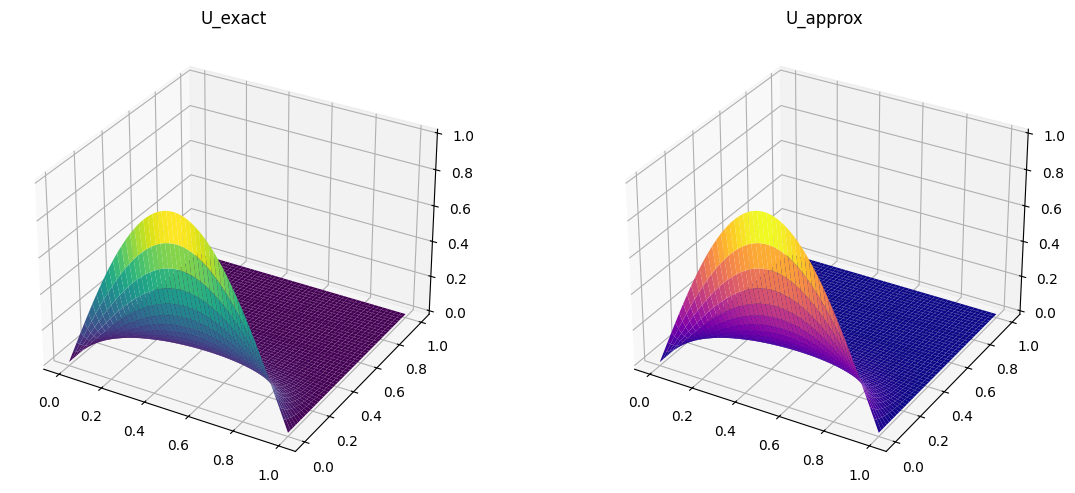

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
# تابع تقریب سری فوریه
def U_approx(x, t, theta):
    N = len(theta)
    return sum(theta[k] * np.sin((k+1) * np.pi * x) * np.exp(-((k+1) * np.pi)**2 * t) for k in range(N))

# حل دقیق برای مقایسه
def U_exact(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

# تابع محاسبه اجزای خطا با روش کرانک-نیکلسون
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = (U[0, :] - np.sin(np.pi * x_vals))**2
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_rmse  = np.sqrt(np.mean(U[:, 0]**2))
    bc_right_rmse = np.sqrt(np.mean(U[:, -1]**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه کلی
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم عقاب
def bes_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                   alpha=2, a=10, R=1.5, c1=2, c2=2):
    np.random.seed(0)
    population = np.random.rand(pop_size, dimensions)
    fitness_results = [fitness_function(individual) for individual in population]
    fitness = np.array([f[0] for f in fitness_results])

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx].copy()
    best_fitness = fitness[best_idx]
    best_errors = fitness_results[best_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r = np.random.rand()
            new_pos = best_solution + alpha * r * (population.mean(axis=0) - population[i])
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta = a * np.pi * np.random.rand()
            r_val = theta + R * np.random.rand()
            xr = r_val * np.sin(theta)
            yr = r_val * np.cos(theta)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = population[i] + y * (population[i] - population[(i + 1) % pop_size]) + x * (population[i] - population.mean(axis=0))
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta_s = a * np.pi * np.random.rand()
            r_val = theta_s
            xr = r_val * np.sinh(theta_s)
            yr = r_val * np.cosh(theta_s)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = np.random.rand() * best_solution + x * (population[i] - c1 * population.mean(axis=0)) + y * (population[i] - c2 * best_solution)
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

    return best_solution, best_fitness, best_errors

# اجرای برنامه
if __name__ == "__main__":
    pop_size = 40
    dimensions = 4
    max_iterations = 300

    best_theta, best_loss, best_errors = bes_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # خطای کل روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors = []
    abs_errors = []

    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))

    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")
    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم سه‌بعدی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ازدحام ذرات PSO**

Best θ (PSO): [ 1.00000000e+00  1.13247529e-15 -2.44907433e-15  3.71033778e-15]
Total Loss: 3.201450e-02
PDE RMSE: 3.201450e-02
Initial Condition RMSE: 3.334252e-15
Boundary Left RMSE: 0.000000e+00
Boundary Right RMSE: 3.406641e-17

Mean Error: 9.200011e-17
Mean Absolute Error: 2.016346e-16

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710678      0.70710678      0.00000000
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.70710678      0.70710678      0.00000000
 0.75  0.50      0.00508543      0.00508543      0.00000000
 0.75  1.00      0.00003657      0.00003657      0.00

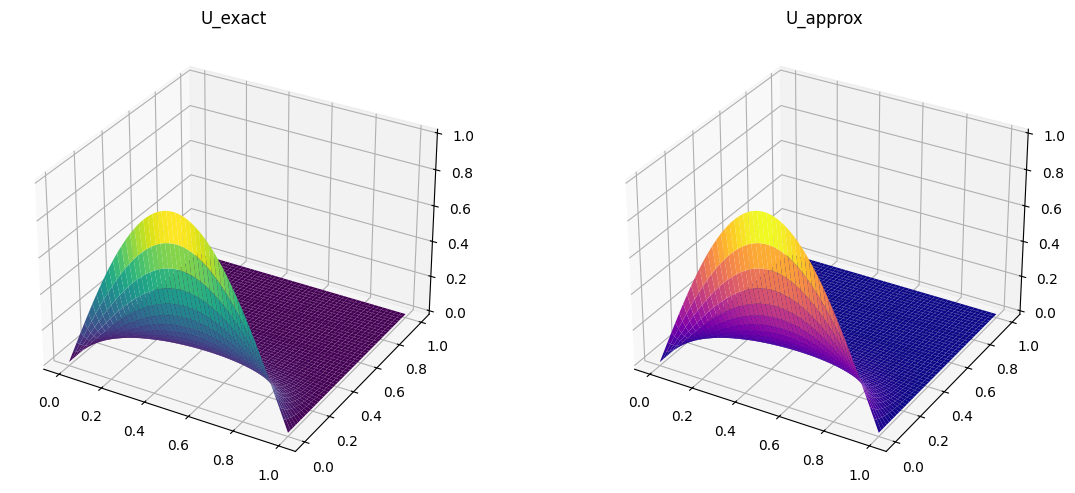

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# تابع تقریب سری فوریه
def U_approx(x, t, theta):
    N = len(theta)
    return sum(theta[k] * np.sin((k+1) * np.pi * x) * np.exp(-((k+1) * np.pi)**2 * t) for k in range(N))

# حل دقیق برای مقایسه
def U_exact(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

# تابع محاسبه اجزای خطا با روش کرانک-نیکلسون
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_err = (U[0, :] - np.sin(np.pi * x_vals))**2
    init_rmse = np.sqrt(np.mean(init_err))

    bc_left_rmse  = np.sqrt(np.mean(U[:, 0]**2))
    bc_right_rmse = np.sqrt(np.mean(U[:, -1]**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه کلی
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم PSO
def pso_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                  w=0.7, c1=1.5, c2=1.5):
    np.random.seed(0)
    X = np.random.rand(pop_size, dimensions)
    V = np.zeros((pop_size, dimensions))
    P = X.copy()
    fitness_results = [fitness_function(ind) for ind in X]
    P_fit = np.array([f[0] for f in fitness_results])

    g_idx = np.argmin(P_fit)
    G = X[g_idx].copy()
    G_fit = P_fit[g_idx]
    G_errors = fitness_results[g_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            V[i] = w * V[i] + c1 * r1 * (P[i] - X[i]) + c2 * r2 * (G - X[i])
            X[i] += V[i]

            fit_all = fitness_function(X[i])
            fit = fit_all[0]
            if fit < P_fit[i]:
                P[i] = X[i].copy()
                P_fit[i] = fit
                if fit < G_fit:
                    G = X[i].copy()
                    G_fit = fit
                    G_errors = fit_all[1:]

    return G, G_fit, G_errors

# اجرای PSO
if __name__ == "__main__":
    pop_size = 40
    dimensions = 4
    max_iterations = 300

    best_theta, best_loss, best_errors = pso_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ (PSO):", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # خطای کل روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors = []
    abs_errors = []

    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))

    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه مقدار تقریبی و تحلیلی در نقاط خاص
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]
    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # نمودار سه‌بعدی حل تحلیلی و تقریبی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ژنتیک GA**

Best θ: [0.98837384 0.10204481 0.20887676 0.00469548]
Total Loss: 1.040618e+00
PDE RMSE: 8.801662e-01
Initial Condition RMSE: 1.604523e-01
Boundary Left RMSE: 0.000000e+00
Boundary Right RMSE: 4.284357e-17

Mean Error: 1.215763e-03
Mean Absolute Error: 7.348212e-03

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.94862882      0.70710678      0.24152204
 0.25  0.50      0.00502631      0.00508543      0.00005912
 0.25  1.00      0.00003615      0.00003657      0.00000043
 0.50  0.00      0.77949708      1.00000000      0.22050292
 0.50  0.50      0.00710827      0.00719188      0.00008361
 0.50  1.00      0.00005112      0.00005172      0.00000060
 0.75  0.00      0.74453920      0.70710678      0.03743242
 0.75  0.50      0.00502631      0.00508543      0.00005912
 0.75  1.00      0.00003615      0.00003657      0.00000043


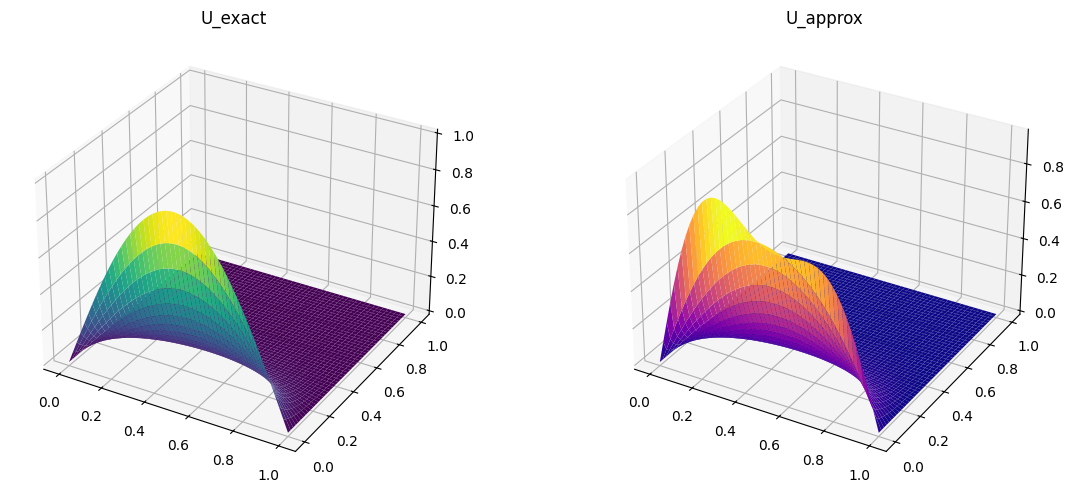

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)

# --- تقریب سری فوریه ---
def U_approx(x, t, theta):
    N = len(theta)
    return sum(theta[k] * np.sin((k+1) * np.pi * x) * np.exp(-((k+1) * np.pi)**2 * t) for k in range(N))

# --- حل دقیق ---
def U_exact(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

# --- اجزای خطا با روش کرانک-نیکلسون ---
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_rmse = np.sqrt(np.mean((U[0, :] - np.sin(np.pi * x_vals))**2))
    bc_left_rmse = np.sqrt(np.mean(U[:, 0]**2))
    bc_right_rmse = np.sqrt(np.mean(U[:, -1]**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# --- تابع هزینه ---
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# --- الگوریتم ژنتیک GA ---
def ga_algorithm(fitness_func, pop_size, dim, generations, crossover_rate=0.8, mutation_rate=0.1):

    def crossover(p1, p2):
        point = np.random.randint(1, dim)
        c1 = np.concatenate([p1[:point], p2[point:]])
        c2 = np.concatenate([p2[:point], p1[point:]])
        return c1, c2

    def mutate(ind):
        idx = np.random.randint(dim)
        ind[idx] += np.random.normal(0, 0.1)
        return ind
    np.random.seed(0)
    population = np.random.rand(pop_size, dim)
    fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
    best_idx = np.argmin(fitness_vals)
    best_solution = population[best_idx].copy()
    best_fit = fitness_vals[best_idx]
    best_errors = fitness_func(best_solution)[1:]

    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            p1, p2 = population[np.random.choice(pop_size, 2, replace=False)]
            if np.random.rand() < crossover_rate:
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if np.random.rand() < mutation_rate:
                c1 = mutate(c1)
            if np.random.rand() < mutation_rate:
                c2 = mutate(c2)
            new_pop.extend([c1, c2])
        population = np.array(new_pop[:pop_size])
        fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
        best_idx = np.argmin(fitness_vals)
        if fitness_vals[best_idx] < best_fit:
            best_solution = population[best_idx].copy()
            best_fit = fitness_vals[best_idx]
            best_errors = fitness_func(best_solution)[1:]

    return best_solution, best_fit, best_errors

# --- اجرای برنامه ---
if __name__ == "__main__":
    pop_size = 40
    dimensions = 4  # تعداد پارامترهای سری فوریه
    max_iterations = 300

    best_theta, best_loss, best_errors = ga_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # خطا روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []

    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))

    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه در چند نقطه خاص
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم حل تحلیلی و تقریبی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_app_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exa_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exa_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_app_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم وال یا نهنگ WOA**

Best θ (WOA): [ 1.00000000e+00  2.45866667e-15 -6.95369546e-16  5.29800400e-16]
Total Loss: 3.201450e-02
PDE RMSE: 3.201450e-02
Initial Condition RMSE: 3.880037e-15
Boundary Left RMSE: 0.000000e+00
Boundary Right RMSE: 3.406641e-17

Mean Error: -3.799897e-16
Mean Absolute Error: 3.799897e-16

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710678      0.70710678      0.00000000
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.70710678      0.70710678      0.00000000
 0.75  0.50      0.00508543      0.00508543      0.00000000
 0.75  1.00      0.00003657      0.00003657      0.0

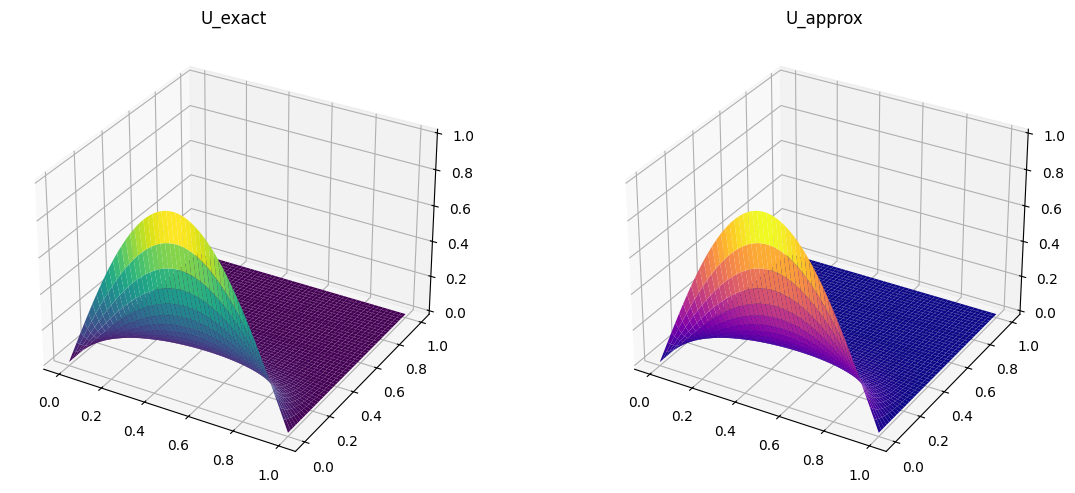

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# تابع تقریب سری فوریه
def U_approx(x, t, theta):
    K = len(theta)
    return sum(theta[k] * np.sin((k + 1) * np.pi * x) * np.exp(-((k + 1) * np.pi)**2 * t) for k in range(K))

# جواب تحلیلی
def U_exact(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

# محاسبه اجزای خطا برای تابع هدف
def compute_errors(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_rmse = np.sqrt(np.mean((U[0, :] - np.sin(np.pi * x_vals))**2))
    bc_left_rmse  = np.sqrt(np.mean(U[:, 0]**2))
    bc_right_rmse = np.sqrt(np.mean(U[:, -1]**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هدف کلی
def fitness_function(theta, λ_init=1.0, λ_bc=1.0):
    pde_rmse, init_rmse, bc_left, bc_right = compute_errors(theta)
    loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left + bc_right)
    return loss, pde_rmse, init_rmse, bc_left, bc_right

# الگوریتم نهنگ
def whale_optimization(fitness_fn, pop_size, dim, max_iter, lb=-5, ub=5):
    population = lb + (ub - lb) * np.random.rand(pop_size, dim)
    fitness_values = np.array([fitness_fn(ind)[0] for ind in population])

    best_idx = np.argmin(fitness_values)
    best_sol = population[best_idx].copy()
    best_fit = fitness_values[best_idx]
    best_errs = fitness_fn(best_sol)[1:]

    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        for i in range(pop_size):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-1, 1)
            b = 1

            if p < 0.5:
                if np.linalg.norm(A) < 1:
                    D = np.abs(C * best_sol - population[i])
                    new_pos = best_sol - A * D
                else:
                    rand_idx = np.random.randint(pop_size)
                    X_rand = population[rand_idx]
                    D = np.abs(C * X_rand - population[i])
                    new_pos = X_rand - A * D
            else:
                D = np.abs(best_sol - population[i])
                new_pos = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_sol

            new_pos = np.clip(new_pos, lb, ub)
            new_fit = fitness_fn(new_pos)[0]

            if new_fit < fitness_values[i]:
                population[i] = new_pos
                fitness_values[i] = new_fit
                if new_fit < best_fit:
                    best_sol = new_pos.copy()
                    best_fit = new_fit
                    best_errs = fitness_fn(best_sol)[1:]

    return best_sol, best_fit, best_errs

# اجرای نهایی (ساختار خروجی دقیقاً مثل PSO)
if __name__ == "__main__":
    pop_size = 40
    dim = 4
    max_iter = 300
    lb, ub = -5, 5

    best_theta, best_loss, best_errors = whale_optimization(fitness_function, pop_size, dim, max_iter, lb, ub)

    print("Best θ (WOA):", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # خطای کل روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors = []
    abs_errors = []

    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))

    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه مقدار تقریبی و تحلیلی در نقاط خاص
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]
    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # نمودار سه‌بعدی حل تحلیلی و تقریبی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **مسئله سوم **

**# 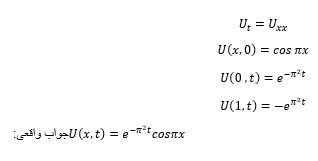**

# **الگوریتم عقاب  BES **

Best θ: [ 1.00000000e+00 -1.01395624e-16  1.68074418e-15  2.08471719e-16]
Total Loss: 3.028269e-02
PDE RMSE: 3.028269e-02
Initial Condition RMSE: 1.373586e-15
Boundary Left RMSE: 2.534015e-16
Boundary Right RMSE: 2.166933e-16

Mean Error: -3.139485e-19
Mean Absolute Error: 1.067049e-16

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710678      0.70710678      0.00000000
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      0.00000000      0.00000000      0.00000000
 0.50  0.50      0.00000000      0.00000000      0.00000000
 0.50  1.00      0.00000000      0.00000000      0.00000000
 0.75  0.00     -0.70710678     -0.70710678      0.00000000
 0.75  0.50     -0.00508543     -0.00508543      0.00000000
 0.75  1.00     -0.00003657     -0.00003657      0.0000000

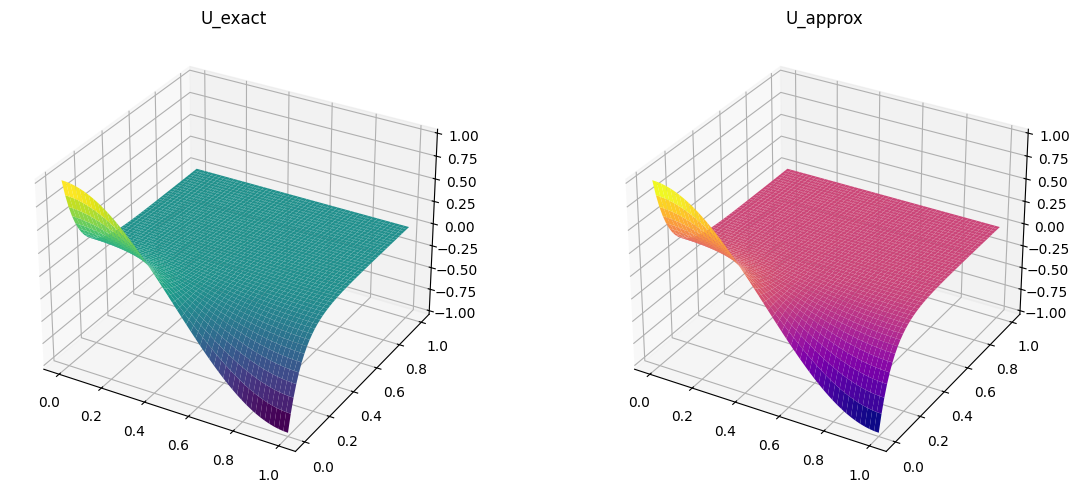

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
# تقریب سری فوریه
def U_approx(x, t, theta):
    K = len(theta)
    return sum(theta[k] * np.cos((k + 1) * np.pi * x) * np.exp(-((k + 1) * np.pi) ** 2 * t) for k in range(K))

# جواب دقیق
def U_exact(x, t):
    return np.cos(np.pi * x) * np.exp(-np.pi**2 * t)

# اجزای خطا (کرانک-نیکلسون)
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse  = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم BES
def bes_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                   alpha=2, a=10, R=1.5, c1=2, c2=2):
    np.random.seed(0)
    population = np.random.rand(pop_size, dimensions)
    fitness_results = [fitness_function(individual) for individual in population]
    fitness = np.array([f[0] for f in fitness_results])

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx].copy()
    best_fitness = fitness[best_idx]
    best_errors = fitness_results[best_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r = np.random.rand()
            new_pos = best_solution + alpha * r * (population.mean(axis=0) - population[i])
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta = a * np.pi * np.random.rand()
            r_val = theta + R * np.random.rand()
            xr = r_val * np.sin(theta)
            yr = r_val * np.cos(theta)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = population[i] + y * (population[i] - population[(i + 1) % pop_size]) + x * (population[i] - population.mean(axis=0))
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta_s = a * np.pi * np.random.rand()
            r_val = theta_s
            xr = r_val * np.sinh(theta_s)
            yr = r_val * np.cosh(theta_s)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = np.random.rand() * best_solution + x * (population[i] - c1 * population.mean(axis=0)) + y * (population[i] - c2 * best_solution)
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

    return best_solution, best_fitness, best_errors

# اجرای الگوریتم
if __name__ == "__main__":
    pop_size = 40
    dimensions = 4
    max_iterations = 300

    best_theta, best_loss, best_errors = bes_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")
    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ازدحام ذرات PSO**

Best θ (PSO): [ 1.00000000e+00 -6.41157045e-16  3.96563758e-15  2.75634881e-15]
Total Loss (PSO): 3.028269e-02
PDE RMSE: 3.028269e-02
Initial Condition RMSE: 3.500714e-15
Boundary Left RMSE: 1.340798e-15
Boundary Right RMSE: 4.475452e-16

Mean Error: 4.666406e-18
Mean Absolute Error: 1.552404e-16

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710678      0.70710678      0.00000000
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      0.00000000      0.00000000      0.00000000
 0.50  0.50      0.00000000      0.00000000      0.00000000
 0.50  1.00      0.00000000      0.00000000      0.00000000
 0.75  0.00     -0.70710678     -0.70710678      0.00000000
 0.75  0.50     -0.00508543     -0.00508543      0.00000000
 0.75  1.00     -0.00003657     -0.00003657    

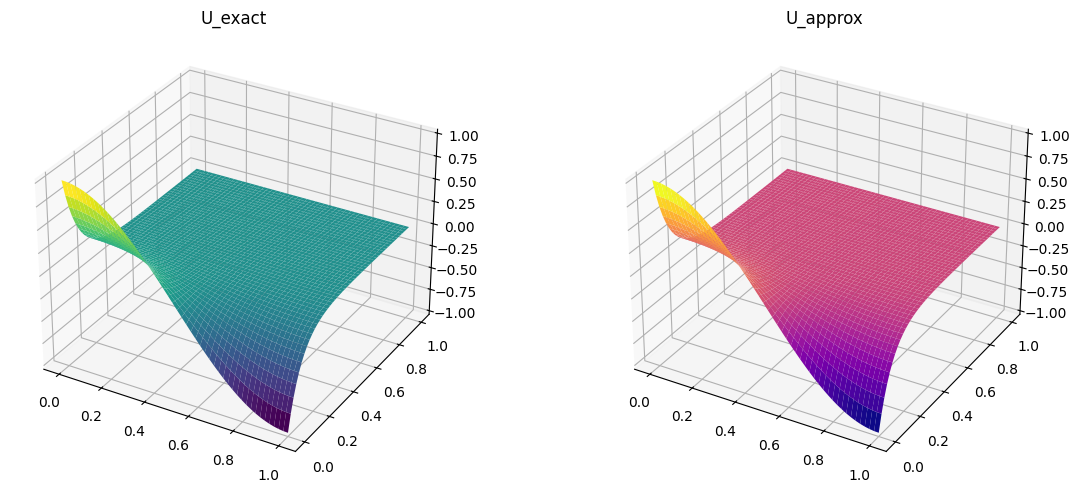

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# تقریب سری فوریه
def U_approx(x, t, theta):
    K = len(theta)
    return sum(theta[k] * np.cos((k + 1) * np.pi * x) * np.exp(-((k + 1) * np.pi) ** 2 * t) for k in range(K))

# جواب دقیق
def U_exact(x, t):
    return np.cos(np.pi * x) * np.exp(-np.pi**2 * t)

# اجزای خطا (کرانک-نیکلسون)
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse  = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم PSO برای بهینه‌سازی
def pso_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                  w=0.7, c1=1.5, c2=1.5):
    np.random.seed(0)
    X = np.random.rand(pop_size, dimensions)  # موقعیت ذرات
    V = np.zeros((pop_size, dimensions))      # سرعت ذرات
    P = X.copy()                              # بهترین موقعیت فردی
    fitness_results = [fitness_function(ind) for ind in X]
    P_fit = np.array([f[0] for f in fitness_results])

    g_idx = np.argmin(P_fit)
    G = X[g_idx].copy()                       # بهترین موقعیت کل
    G_fit = P_fit[g_idx]
    G_errors = fitness_results[g_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            V[i] = w * V[i] + c1 * r1 * (P[i] - X[i]) + c2 * r2 * (G - X[i])
            X[i] += V[i]

            fit_all = fitness_function(X[i])
            fit = fit_all[0]
            if fit < P_fit[i]:
                P[i] = X[i].copy()
                P_fit[i] = fit
                if fit < G_fit:
                    G = X[i].copy()
                    G_fit = fit
                    G_errors = fit_all[1:]

    return G, G_fit, G_errors

# اجرای الگوریتم
if __name__ == "__main__":
    pop_size = 40
    dimensions = 4
    max_iterations = 300

    best_theta, best_loss, best_errors = pso_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ (PSO):", best_theta)
    print(f"Total Loss (PSO): {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ژنتیک GA**

Best θ: [ 1.00147277  1.00058698  0.00212037 -0.0050621 ]
Total Loss: 4.552821e-02
PDE RMSE: 4.136998e-02
Initial Condition RMSE: 3.059196e-03
Boundary Left RMSE: 8.565219e-04
Boundary Right RMSE: 2.425062e-04

Mean Error: 4.976883e-05
Mean Absolute Error: 1.956373e-04

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      1.41060793      1.41421356      0.00360563
 0.25  0.50      0.01018133      0.01017086      0.00001047
 0.25  1.00      0.00007322      0.00007315      0.00000008
 0.50  0.00      0.99846662      1.00000000      0.00153338
 0.50  0.50      0.00719610      0.00719188      0.00000422
 0.50  1.00      0.00005175      0.00005172      0.00000003
 0.75  0.00      0.00443575      0.00000000      0.00443575
 0.75  0.50     -0.00000450      0.00000000      0.00000450
 0.75  1.00     -0.00000003      0.00000000      0.00000003


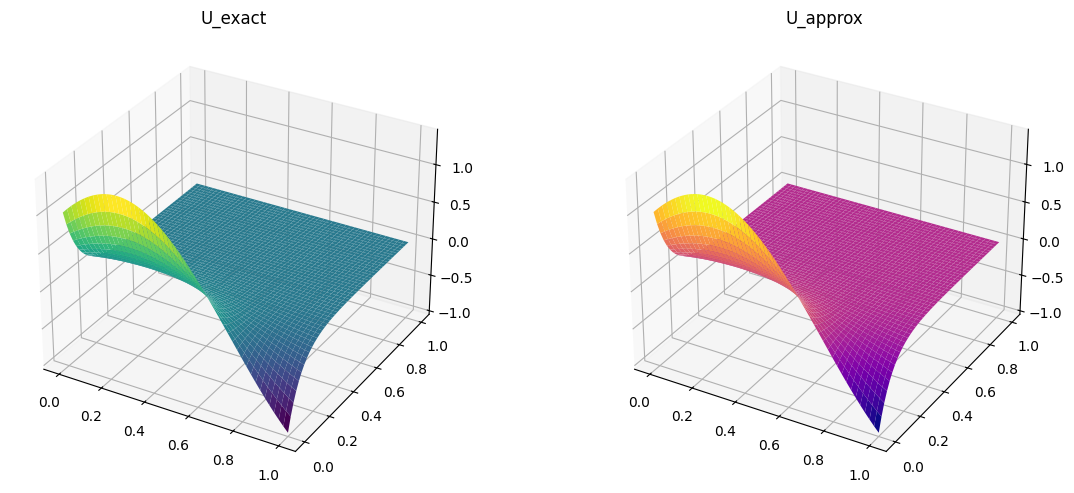

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# --- تعریف تابع تقریبی
def U_approx(x, t, theta):
    K = len(theta) // 2
    u = 0.0
    for k in range(K):
        A = theta[2 * k]
        B = theta[2 * k + 1]
        λ = ((k + 1) * np.pi) ** 2
        u += A * np.cos((k + 1) * np.pi * x) * np.exp(-λ * t)
        u += B * np.sin((k + 1) * np.pi * x) * np.exp(-λ * t)
    return u

# --- حل دقیق
def U_exact(x, t):
    return (np.sin(np.pi * x) + np.cos(np.pi * x)) * np.exp(-np.pi**2 * t)

# --- محاسبه خطاهای مختلف
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    # PDE RMSE
    pde_err = []
    for n in range(num_t - 1):
        u_xx_n = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    # Initial Condition
    init_target = np.sin(np.pi * x_vals) + np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    # Boundary Conditions
    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# --- تابع هدف برای الگوریتم GA
def fitness_function(theta):
    λ_init, λ_bc = 1, 1
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# --- الگوریتم ژنتیک استاندارد
def ga_algorithm(fitness_func, pop_size, dimensions, max_generations,
                 crossover_rate=0.8, mutation_rate=0.1):
    population = np.random.uniform(-1, 1, (pop_size, dimensions))
    fitness = np.array([fitness_func(ind)[0] for ind in population])
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]
    best_errors = fitness_func(best_solution)[1:]

    for gen in range(max_generations):
        new_population = []
        for _ in range(pop_size // 2):
            # انتخاب والد با تورنومنت
            idxs = np.random.choice(pop_size, 4, replace=False)
            p1 = population[idxs[:2]][np.argmin(fitness[idxs[:2]])]
            p2 = population[idxs[2:]][np.argmin(fitness[idxs[2:]])]

            # کراس اور
            if np.random.rand() < crossover_rate:
                alpha = np.random.rand(dimensions)
                child1 = alpha * p1 + (1 - alpha) * p2
                child2 = alpha * p2 + (1 - alpha) * p1
            else:
                child1, child2 = p1.copy(), p2.copy()

            # جهش
            for child in [child1, child2]:
                mutation_mask = np.random.rand(dimensions) < mutation_rate
                child[mutation_mask] += np.random.normal(0, 0.1, size=dimensions)[mutation_mask]
                new_population.append(child)

        population = np.clip(np.array(new_population), -2, 2)
        fitness = np.array([fitness_func(ind)[0] for ind in population])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_solution = population[current_best_idx]
            best_fitness = fitness[current_best_idx]
            best_errors = fitness_func(best_solution)[1:]

    return best_solution, best_fitness, best_errors

# --- اجرا
pop_size = 40
K = 2
dimensions = 2 * K
max_generations = 300

best_theta, total_loss, errors = ga_algorithm(fitness_function, pop_size, dimensions, max_generations)

print("Best θ:", best_theta)
print(f"Total Loss: {total_loss:.6e}")
print(f"PDE RMSE: {errors[0]:.6e}")
print(f"Initial Condition RMSE: {errors[1]:.6e}")
print(f"Boundary Left RMSE: {errors[2]:.6e}")
print(f"Boundary Right RMSE: {errors[3]:.6e}")

# بررسی خطاهای عددی
x_vals = np.linspace(0, 1, 20)
t_vals = np.linspace(0, 1, 20)
errors_list, abs_errors = [], []
for x in x_vals:
    for t in t_vals:
        u_app = U_approx(x, t, best_theta)
        u_exa = U_exact(x, t)
        errors_list.append(u_app - u_exa)
        abs_errors.append(abs(u_app - u_exa))

print(f"\nMean Error: {np.mean(errors_list):.6e}")
print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

# جدول مقایسه
x_sample = [0.25, 0.5, 0.75]
t_sample = [0.0, 0.5, 1.0]
print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
print("-" * 60)
for x in x_sample:
    for t in t_sample:
        ua = U_approx(x, t, best_theta)
        ue = U_exact(x, t)
        err = abs(ua - ue)
        print(f"{x:>5.2f} {t:>5.2f} {ua:>15.8f} {ue:>15.8f} {err:>15.8f}")

# نمودارهای سه‌بعدی
x_plot = np.linspace(0, 1, 50)
t_plot = np.linspace(0, 1, 50)
X, T = np.meshgrid(x_plot, t_plot)
U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
U_exact_vals = np.vectorize(U_exact)(X, T)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
ax1.set_title("U_exact")
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
ax2.set_title("U_approx")
plt.tight_layout()
plt.show()


# **الگوریتم وال یا نهنگ WOA**

Best θ: [ 9.99999942e-01 -2.22050054e-07  7.17363995e-08  1.87666702e-07]
Total Loss: 3.028290e-02
PDE RMSE: 3.028266e-02
Initial Condition RMSE: 2.103908e-07
Boundary Left RMSE: 1.588720e-08
Boundary Right RMSE: 1.195155e-08

Mean Error: -1.652945e-10
Mean Absolute Error: 1.173223e-08

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      0.70710650      0.70710678      0.00000028
 0.25  0.50      0.00508543      0.00508543      0.00000000
 0.25  1.00      0.00003657      0.00003657      0.00000000
 0.50  0.00      0.00000041      0.00000000      0.00000041
 0.50  0.50      0.00000000      0.00000000      0.00000000
 0.50  1.00      0.00000000      0.00000000      0.00000000
 0.75  0.00     -0.70710688     -0.70710678      0.00000010
 0.75  0.50     -0.00508543     -0.00508543      0.00000000
 0.75  1.00     -0.00003657     -0.00003657      0.0000000

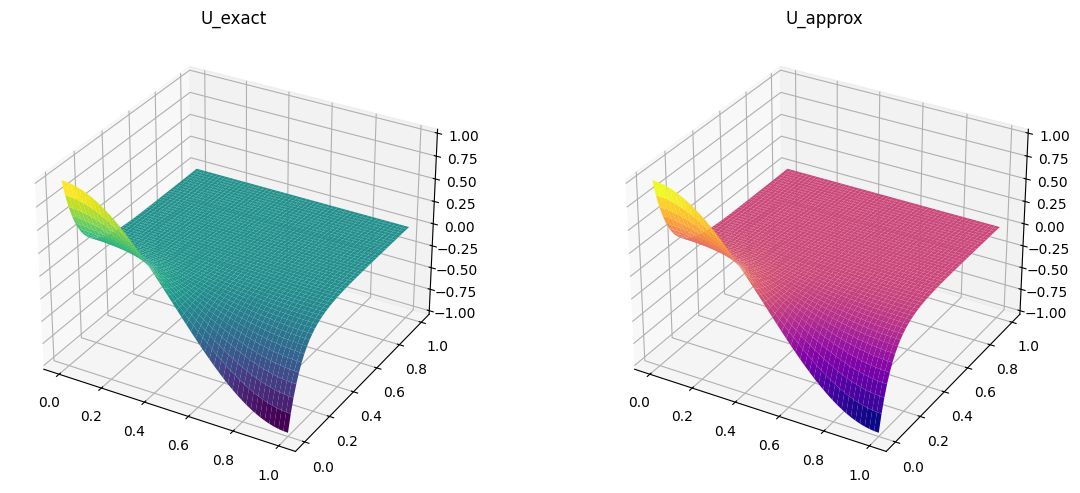

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
# تقریب سری فوریه
def U_approx(x, t, theta):
    K = len(theta)
    return sum(theta[k] * np.cos((k + 1) * np.pi * x) * np.exp(-((k + 1) * np.pi) ** 2 * t) for k in range(K))

# جواب دقیق
def U_exact(x, t):
    return np.cos(np.pi * x) * np.exp(-np.pi**2 * t)

# محاسبه اجزای خطا (کرانک-نیکلسون)
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse  = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1.0, 1.0
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم بهینه‌سازی نهنگ (WOA)
def woa(fitness_function, pop_size, dim, max_iter, lb=-3, ub=3):
    np.random.seed(0)
    # مقداردهی اولیه جمعیت
    population = lb + (ub - lb) * np.random.rand(pop_size, dim)
    fitnesses = np.array([fitness_function(ind)[0] for ind in population])

    # بهترین راه‌حل فعلی
    best_idx = np.argmin(fitnesses)
    best_solution = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    best_errors = fitness_function(best_solution)[1:]

    # پارامترهای الگوریتم
    a = 2.0  # کاهش تدریجی پارامتر a

    for t in range(max_iter):
        a = 2.0 - t * (2.0 / max_iter)  # خطی کاهش پیدا می‌کند

        for i in range(pop_size):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-1, 1)

            if p < 0.5:
                if np.linalg.norm(A) < 1:
                    # حرکت به سمت بهترین نهنگ (احاطه طعمه)
                    D = np.abs(C * best_solution - population[i])
                    new_pos = best_solution - A * D
                else:
                    # حرکت تصادفی به سمت نهنگ تصادفی (جستجوی طعمه)
                    rand_idx = np.random.randint(pop_size)
                    X_rand = population[rand_idx]
                    D = np.abs(C * X_rand - population[i])
                    new_pos = X_rand - A * D
            else:
                # حمله حبابی (Spiral update)
                D_prime = np.abs(best_solution - population[i])
                b = 1  # پارامتر شکل مارپیچ
                new_pos = D_prime * np.exp(b * l) * np.cos(2 * np.pi * l) + best_solution

            # محدود کردن به بازه
            new_pos = np.clip(new_pos, lb, ub)

            # ارزیابی و به‌روزرسانی
            fit_new = fitness_function(new_pos)[0]
            if fit_new < fitnesses[i]:
                population[i] = new_pos
                fitnesses[i] = fit_new

                if fit_new < best_fitness:
                    best_solution = new_pos.copy()
                    best_fitness = fit_new
                    best_errors = fitness_function(best_solution)[1:]

    return best_solution, best_fitness, best_errors


if __name__ == "__main__":
    pop_size = 40
    dim = 4
    max_iter = 300
    lb = -3  # بازه جستجوی θ ها (می‌توانید تغییر دهید)
    ub = 3

    best_theta, best_loss, best_errors = woa(fitness_function, pop_size, dim, max_iter, lb, ub)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **مسئله چهارم **

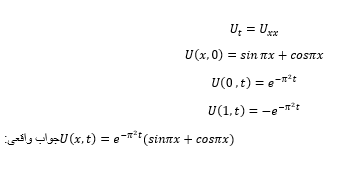

# **الگوریتم عقاب BES**

Best θ: [ 1.00000000e+00  1.00000000e+00  8.07410339e-16 -4.19253567e-15]
Total Loss: 4.406779e-02
PDE RMSE: 4.406779e-02
Initial Condition RMSE: 2.970916e-15
Boundary Left RMSE: 2.001483e-16
Boundary Right RMSE: 2.053115e-16

Mean Error: -3.299109e-17
Mean Absolute Error: 1.657365e-16

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      1.41421356      1.41421356      0.00000000
 0.25  0.50      0.01017086      0.01017086      0.00000000
 0.25  1.00      0.00007315      0.00007315      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.00000000      0.00000000      0.00000000
 0.75  0.50     -0.00000000      0.00000000      0.00000000
 0.75  1.00     -0.00000000      0.00000000      0.0000000

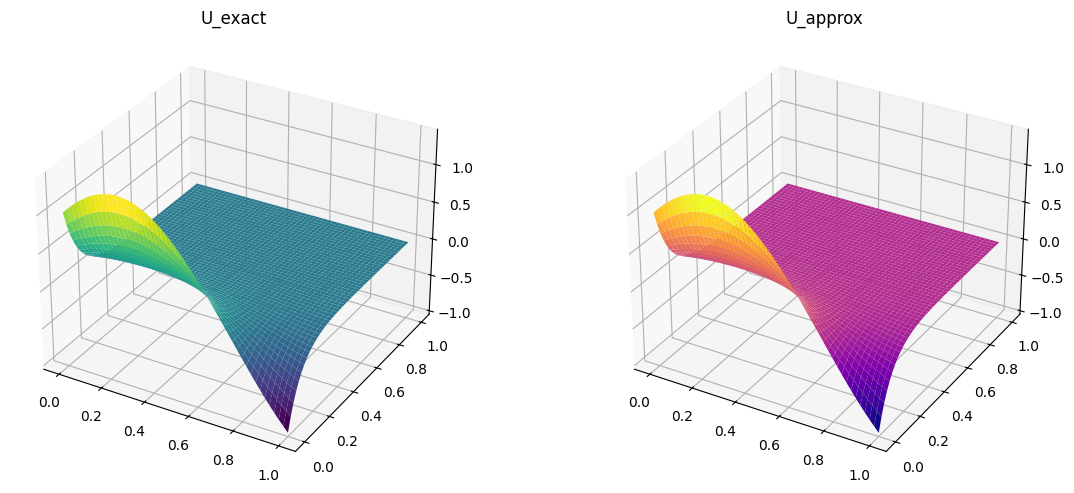

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
# تقریب سری فوریه ترکیبی
def U_approx(x, t, theta):
    K = len(theta) // 2
    u = 0.0
    for k in range(K):
        A = theta[2 * k]
        B = theta[2 * k + 1]
        λ = ((k + 1) * np.pi) ** 2
        u += A * np.cos((k + 1) * np.pi * x) * np.exp(-λ * t)
        u += B * np.sin((k + 1) * np.pi * x) * np.exp(-λ * t)
    return u

# جواب دقیق
def U_exact(x, t):
    return (np.sin(np.pi * x) + np.cos(np.pi * x)) * np.exp(-np.pi**2 * t)

# اجزای خطا (کرانک-نیکلسون)
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.sin(np.pi * x_vals) + np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1, 1
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم BES
def bes_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                   alpha=2, a=10, R=1.5, c1=2, c2=2):
    np.random.seed(0)
    population = np.random.rand(pop_size, dimensions)
    fitness_results = [fitness_function(individual) for individual in population]
    fitness = np.array([f[0] for f in fitness_results])

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx].copy()
    best_fitness = fitness[best_idx]
    best_errors = fitness_results[best_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r = np.random.rand()
            new_pos = best_solution + alpha * r * (population.mean(axis=0) - population[i])
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta = a * np.pi * np.random.rand()
            r_val = theta + R * np.random.rand()
            xr = r_val * np.sin(theta)
            yr = r_val * np.cos(theta)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = population[i] + y * (population[i] - population[(i + 1) % pop_size]) + x * (population[i] - population.mean(axis=0))
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

            theta_s = a * np.pi * np.random.rand()
            r_val = theta_s
            xr = r_val * np.sinh(theta_s)
            yr = r_val * np.cosh(theta_s)
            x = xr / (np.max(np.abs(xr)) + 1e-8)
            y = yr / (np.max(np.abs(yr)) + 1e-8)
            new_pos = np.random.rand() * best_solution + x * (population[i] - c1 * population.mean(axis=0)) + y * (population[i] - c2 * best_solution)
            new_fit_all = fitness_function(new_pos)
            if new_fit_all[0] < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit_all[0]
                if new_fit_all[0] < best_fitness:
                    best_solution, best_fitness = new_pos.copy(), new_fit_all[0]
                    best_errors = new_fit_all[1:]

    return best_solution, best_fitness, best_errors

# اجرای الگوریتم
if __name__ == "__main__":
    pop_size = 40
    K = 2
    dimensions = 2 * K
    max_iterations = 300

    best_theta, best_loss, best_errors = bes_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")
    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ازدحام ذرات PSO**

Best θ: [ 1.00000000e+00  1.00000000e+00  3.44423520e-14 -1.82868112e-13]
Total Loss: 4.406779e-02
PDE RMSE: 4.406779e-02
Initial Condition RMSE: 9.272835e-14
Boundary Left RMSE: 4.017011e-14
Boundary Right RMSE: 2.683687e-14

Mean Error: -3.879045e-15
Mean Absolute Error: 9.640266e-15

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      1.41421356      1.41421356      0.00000000
 0.25  0.50      0.01017086      0.01017086      0.00000000
 0.25  1.00      0.00007315      0.00007315      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.00000000      0.00000000      0.00000000
 0.75  0.50     -0.00000000      0.00000000      0.00000000
 0.75  1.00     -0.00000000      0.00000000      0.0000000

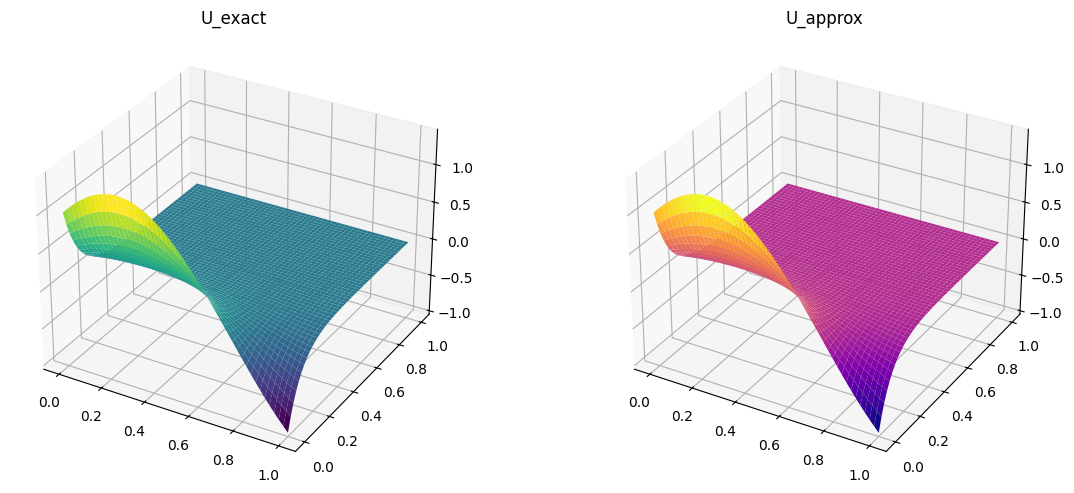

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# -----------------------------
# تقریب سری فوریه ترکیبی
# -----------------------------
def U_approx(x, t, theta):
    K = len(theta) // 2
    u = 0.0
    for k in range(K):
        A = theta[2 * k]
        B = theta[2 * k + 1]
        λ = ((k + 1) * np.pi) ** 2
        u += A * np.cos((k + 1) * np.pi * x) * np.exp(-λ * t)
        u += B * np.sin((k + 1) * np.pi * x) * np.exp(-λ * t)
    return u

# -----------------------------
# جواب دقیق
# -----------------------------
def U_exact(x, t):
    return (np.sin(np.pi * x) + np.cos(np.pi * x)) * np.exp(-np.pi**2 * t)

# -----------------------------
# محاسبه اجزای خطا
# -----------------------------
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.sin(np.pi * x_vals) + np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# -----------------------------
# تابع هزینه
# -----------------------------
def fitness_function(theta):
    λ_init, λ_bc = 1, 1
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# -----------------------------
# الگوریتم PSO
# -----------------------------
def pso_algorithm(fitness_function, pop_size, dimensions, max_iterations,
                  w=0.7, c1=1.5, c2=1.5):
    np.random.seed(0)
    X = np.random.rand(pop_size, dimensions)
    V = np.zeros((pop_size, dimensions))
    P = X.copy()

    fitness_all = [fitness_function(ind) for ind in X]
    fitness_vals = np.array([f[0] for f in fitness_all])
    P_fit = fitness_vals.copy()

    g_idx = np.argmin(fitness_vals)
    G = X[g_idx].copy()
    G_fit = fitness_vals[g_idx]
    G_errors = fitness_all[g_idx][1:]

    for _ in range(max_iterations):
        for i in range(pop_size):
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            V[i] = w * V[i] + c1 * r1 * (P[i] - X[i]) + c2 * r2 * (G - X[i])
            X[i] += V[i]

            fit_all = fitness_function(X[i])
            fit = fit_all[0]
            if fit < P_fit[i]:
                P[i] = X[i].copy()
                P_fit[i] = fit
                if fit < G_fit:
                    G = X[i].copy()
                    G_fit = fit
                    G_errors = fit_all[1:]
    return G, G_fit, G_errors

# -----------------------------
# اجرای برنامه
# -----------------------------
if __name__ == "__main__":
    pop_size = 40
    K = 2
    dimensions = 2 * K
    max_iterations = 300

    best_theta, best_loss, best_errors = pso_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه دقیق و تقریبی در چند نقطه
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]
    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار سه‌بعدی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم ژنتیک GA**

Best θ: [0.96366276 0.92559664 0.07103606 0.0871293 ]
Total Loss: 2.474059e-01
PDE RMSE: 1.173831e-01
Initial Condition RMSE: 9.585426e-02
Boundary Left RMSE: 8.921889e-03
Boundary Right RMSE: 2.524666e-02

Mean Error: -5.337400e-03
Mean Absolute Error: 7.879361e-03

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      1.42303743      1.41421356      0.00882387
 0.25  0.50      0.00960770      0.01017086      0.00056316
 0.25  1.00      0.00006910      0.00007315      0.00000405
 0.50  0.00      0.85456058      1.00000000      0.14543942
 0.50  0.50      0.00665678      0.00719188      0.00053510
 0.50  1.00      0.00004787      0.00005172      0.00000385
 0.75  0.00     -0.11404611      0.00000000      0.11404611
 0.75  0.50     -0.00019358      0.00000000      0.00019358
 0.75  1.00     -0.00000139      0.00000000      0.00000139


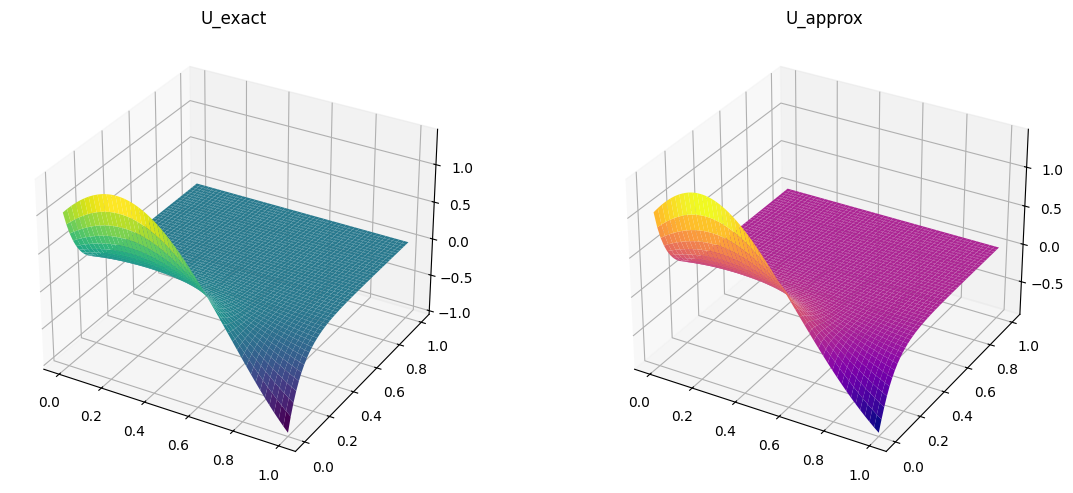

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# تقریب سری فوریه ترکیبی
def U_approx(x, t, theta):
    K = len(theta) // 2
    u = 0.0
    for k in range(K):
        A = theta[2 * k]
        B = theta[2 * k + 1]
        λ = ((k + 1) * np.pi) ** 2
        u += A * np.cos((k + 1) * np.pi * x) * np.exp(-λ * t)
        u += B * np.sin((k + 1) * np.pi * x) * np.exp(-λ * t)
    return u

# جواب دقیق
def U_exact(x, t):
    return (np.sin(np.pi * x) + np.cos(np.pi * x)) * np.exp(-np.pi**2 * t)

# اجزای خطا
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.sin(np.pi * x_vals) + np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1, 1
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم ژنتیک
def ga_algorithm(fitness_func, pop_size, dim, generations, crossover_rate=0.8, mutation_rate=0.1):

    def crossover(p1, p2):
        point = np.random.randint(1, dim)
        c1 = np.concatenate([p1[:point], p2[point:]])
        c2 = np.concatenate([p2[:point], p1[point:]])
        return c1, c2

    def mutate(ind):
        idx = np.random.randint(dim)
        ind[idx] += np.random.normal(0, 0.1)
        return ind

    population = np.random.rand(pop_size, dim)
    fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
    best_idx = np.argmin(fitness_vals)
    best_solution = population[best_idx].copy()
    best_fit = fitness_vals[best_idx]
    best_errors = fitness_func(best_solution)[1:]

    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            p1, p2 = population[np.random.choice(pop_size, 2, replace=False)]
            if np.random.rand() < crossover_rate:
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if np.random.rand() < mutation_rate:
                c1 = mutate(c1)
            if np.random.rand() < mutation_rate:
                c2 = mutate(c2)
            new_pop.extend([c1, c2])
        population = np.array(new_pop[:pop_size])
        fitness_vals = np.array([fitness_func(ind)[0] for ind in population])
        best_idx = np.argmin(fitness_vals)
        if fitness_vals[best_idx] < best_fit:
            best_solution = population[best_idx].copy()
            best_fit = fitness_vals[best_idx]
            best_errors = fitness_func(best_solution)[1:]

    return best_solution, best_fit, best_errors

# اجرای الگوریتم
if __name__ == "__main__":
    pop_size = 40
    K = 2
    dimensions = 2 * K
    max_iterations = 300

    best_theta, best_loss, best_errors = ga_algorithm(fitness_function, pop_size, dimensions, max_iterations)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # مقایسه تقریبی و تحلیلی
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # بررسی چند نقطه خاص
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]
    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # رسم نمودار سه‌بعدی
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()


# **الگوریتم وال یا نهنگ WOA**

Best θ: [ 1.00000000e+00  1.00000000e+00  3.47011786e-10 -9.15664186e-10]
Total Loss: 4.406779e-02
PDE RMSE: 4.406779e-02
Initial Condition RMSE: 5.299061e-10
Boundary Left RMSE: 1.565480e-10
Boundary Right RMSE: 4.303705e-11

Mean Error: 1.833010e-11
Mean Absolute Error: 3.897640e-11

مقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):
    x     t        U_approx         U_exact         |Error|
------------------------------------------------------------
 0.25  0.00      1.41421356      1.41421356      0.00000000
 0.25  0.50      0.01017086      0.01017086      0.00000000
 0.25  1.00      0.00007315      0.00007315      0.00000000
 0.50  0.00      1.00000000      1.00000000      0.00000000
 0.50  0.50      0.00719188      0.00719188      0.00000000
 0.50  1.00      0.00005172      0.00005172      0.00000000
 0.75  0.00      0.00000000      0.00000000      0.00000000
 0.75  0.50     -0.00000000      0.00000000      0.00000000
 0.75  1.00     -0.00000000      0.00000000      0.00000000

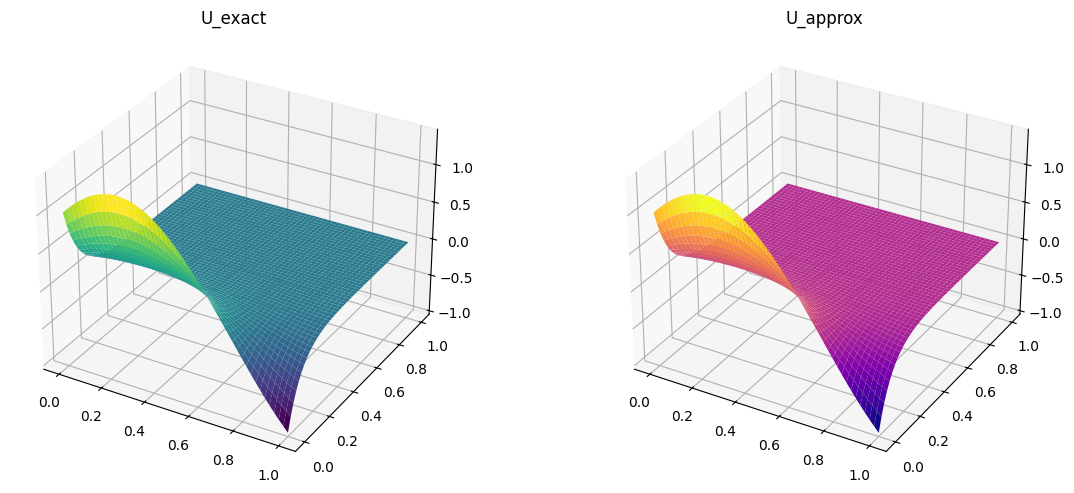

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# تقریب سری فوریه ترکیبی
def U_approx(x, t, theta):
    K = len(theta) // 2
    u = 0.0
    for k in range(K):
        A = theta[2 * k]
        B = theta[2 * k + 1]
        λ = ((k + 1) * np.pi) ** 2
        u += A * np.cos((k + 1) * np.pi * x) * np.exp(-λ * t)
        u += B * np.sin((k + 1) * np.pi * x) * np.exp(-λ * t)
    return u

# جواب دقیق
def U_exact(x, t):
    return (np.sin(np.pi * x) + np.cos(np.pi * x)) * np.exp(-np.pi**2 * t)

# محاسبه اجزای خطا (کرانک-نیکلسون)
def compute_components(theta):
    num_x, num_t = 20, 20
    x_vals = np.linspace(0, 1, num_x)
    t_vals = np.linspace(0, 1, num_t)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    U = np.zeros((num_t, num_x))
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            U[i, j] = U_approx(x, t, theta)

    pde_err = []
    for n in range(num_t - 1):
        u_xx_n   = (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2]) / dx**2
        u_xx_np1 = (U[n+1, 2:] - 2 * U[n+1, 1:-1] + U[n+1, :-2]) / dx**2
        u_t      = (U[n+1, 1:-1] - U[n, 1:-1]) / dt
        rhs      = 0.5 * (u_xx_n + u_xx_np1)
        pde_err.extend((u_t - rhs)**2)
    pde_rmse = np.sqrt(np.mean(pde_err))

    init_target = np.sin(np.pi * x_vals) + np.cos(np.pi * x_vals)
    init_rmse = np.sqrt(np.mean((U[0, :] - init_target)**2))

    bc_left_target = np.exp(-np.pi**2 * t_vals)
    bc_right_target = -np.exp(-np.pi**2 * t_vals)
    bc_left_rmse = np.sqrt(np.mean((U[:, 0] - bc_left_target)**2))
    bc_right_rmse = np.sqrt(np.mean((U[:, -1] - bc_right_target)**2))

    return pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# تابع هزینه
def fitness_function(theta):
    λ_init, λ_bc = 1, 1
    pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse = compute_components(theta)
    total_loss = pde_rmse + λ_init * init_rmse + λ_bc * (bc_left_rmse + bc_right_rmse)
    return total_loss, pde_rmse, init_rmse, bc_left_rmse, bc_right_rmse

# الگوریتم بهینه‌سازی نهنگ (WOA)
def woa(fitness_function, pop_size, dim, max_iter, lb=-3, ub=3):
    np.random.seed(0)

    # مقداردهی اولیه جمعیت
    population = lb + (ub - lb) * np.random.rand(pop_size, dim)
    fitnesses = np.array([fitness_function(ind)[0] for ind in population])

    # بهترین راه‌حل فعلی
    best_idx = np.argmin(fitnesses)
    best_solution = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    best_errors = fitness_function(best_solution)[1:]

    for t in range(max_iter):
        a = 2.0 - t * (2.0 / max_iter)  # کاهش خطی پارامتر a

        for i in range(pop_size):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-1, 1)

            if p < 0.5:
                if np.linalg.norm(A) < 1:
                    # احاطه طعمه (بهترین راه‌حل)
                    D = np.abs(C * best_solution - population[i])
                    new_pos = best_solution - A * D
                else:
                    # جستجوی تصادفی طعمه
                    rand_idx = np.random.randint(pop_size)
                    X_rand = population[rand_idx]
                    D = np.abs(C * X_rand - population[i])
                    new_pos = X_rand - A * D
            else:
                # حرکت مارپیچی به سمت طعمه (حمله حبابی)
                D_prime = np.abs(best_solution - population[i])
                b = 1  # پارامتر شکل مارپیچ
                new_pos = D_prime * np.exp(b * l) * np.cos(2 * np.pi * l) + best_solution

            # محدود کردن به بازه مشخص شده
            new_pos = np.clip(new_pos, lb, ub)

            # ارزیابی و به‌روزرسانی
            fit_new = fitness_function(new_pos)[0]
            if fit_new < fitnesses[i]:
                population[i] = new_pos
                fitnesses[i] = fit_new

                if fit_new < best_fitness:
                    best_solution = new_pos.copy()
                    best_fitness = fit_new
                    best_errors = fitness_function(best_solution)[1:]

    return best_solution, best_fitness, best_errors


if __name__ == "__main__":
    pop_size = 40
    K = 2
    dimensions = 2 * K
    max_iter = 300
    lb = -3
    ub = 3

    best_theta, best_loss, best_errors = woa(fitness_function, pop_size, dimensions, max_iter, lb, ub)

    print("Best θ:", best_theta)
    print(f"Total Loss: {best_loss:.6e}")
    print(f"PDE RMSE: {best_errors[0]:.6e}")
    print(f"Initial Condition RMSE: {best_errors[1]:.6e}")
    print(f"Boundary Left RMSE: {best_errors[2]:.6e}")
    print(f"Boundary Right RMSE: {best_errors[3]:.6e}")

    # ارزیابی تقریبی و تحلیلی روی شبکه
    x_vals = np.linspace(0, 1, 20)
    t_vals = np.linspace(0, 1, 20)
    errors, abs_errors = [], []
    for x in x_vals:
        for t in t_vals:
            approx = U_approx(x, t, best_theta)
            exact = U_exact(x, t)
            errors.append(approx - exact)
            abs_errors.append(abs(approx - exact))
    print(f"\nMean Error: {np.mean(errors):.6e}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.6e}")

    # مقایسه دقیق و تقریبی برای چند نقطه خاص از (x, t)
    x_sample = [0.25, 0.5, 0.75]
    t_sample = [0.0, 0.5, 1.0]

    print("\nمقایسه مقدار تقریبی و تحلیلی در نقاط انتخابی (x, t):")
    print(f"{'x':>5} {'t':>5} {'U_approx':>15} {'U_exact':>15} {'|Error|':>15}")
    print("-" * 60)
    for x in x_sample:
        for t in t_sample:
            u_app = U_approx(x, t, best_theta)
            u_exa = U_exact(x, t)
            error = abs(u_app - u_exa)
            print(f"{x:>5.2f} {t:>5.2f} {u_app:>15.8f} {u_exa:>15.8f} {error:>15.8f}")

    # ترسیم نمودار
    x_plot = np.linspace(0, 1, 50)
    t_plot = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_plot, t_plot)
    U_approx_vals = np.vectorize(lambda x, t: U_approx(x, t, best_theta))(X, T)
    U_exact_vals = np.vectorize(U_exact)(X, T)

    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, T, U_exact_vals, cmap='viridis')
    ax1.set_title("U_exact")
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, T, U_approx_vals, cmap='plasma')
    ax2.set_title("U_approx")
    plt.tight_layout()
    plt.show()
